In [49]:
# cd /jet/home/bermudez
# interact -p GPU-shared --gres=gpu:1 -t 08:00:00 -A cis250242p
# module load AI/pytorch_23.02-1.13.1-py3
# conda activate eeg_env
# jupyter notebook --no-browser --ip=0.0.0.0

In [12]:
# %%
config = {
    'root': "/ocean/projects/cis250019p/gandotra/11785-gp-eeg/ds005589",
    'captions': "/ocean/projects/cis250019p/gandotra/11785-gp-eeg/captions.txt",
    'batch_size': 128,
    'num_epochs': 2,
    'model_to_use': "Multiscale", #Multihead|Multiscale
    'lr': 1e-4,
    'weight_decay': 1e-3,
    'label_smoothing': 0.15,
    'max_grad_norm': 2.0,
    'results_path': "results/Finetune_Multihead"
}

# Imports

In [13]:
# %%
import sys
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

from torchinfo import summary
import torch.optim as optim
import torch.nn as nn



from sklearn.metrics import (
    accuracy_score, confusion_matrix,
    precision_recall_fscore_support
)

# Add project path
import os
os.chdir('/jet/home/bermudez/exploring-eeg/4-eeg-classifiers')

# ---- Import modules from .py files ----
from data_extraction.dataset_builder import build_trial_index, split_by_session
from data_extraction.dataloader import make_dataloaders, eeg_collate_fn
from models.eeg_net_bl import EEGNetBL
from models.eeg_multihead_transformer import MultiHeadEEGClassifier
from utils.train_utils import (
    train_model, 
    train_multihead_model
)
from utils.eeg_embeddings import export_all_splits_multihead
from utils.eval_results import (
    evaluate_model,
    collect_predictions,
    plot_confusion_matrix,
    compute_per_class_accuracy,
    compute_global_metrics,
    metrics_to_dataframe,
    top_confusion_pairs
)
from models.eeg_multiscale_transformer import MultiScaleEEGTransformerMH



Device: cuda


In [14]:
save_dir = Path(config['results_path'])
save_dir.mkdir(exist_ok=True, parents=True)

# Dataset

In [15]:
# %%
DATASET_ROOT = Path(config['root'])
CAPTIONS_PATH = Path(config['captions'])

index_df = build_trial_index(DATASET_ROOT, CAPTIONS_PATH)
index_df = split_by_session(index_df)

print(index_df.head())
print("Total labeled trials:", len(index_df))

Found 519 EEG run files under /ocean/projects/cis250019p/gandotra/11785-gp-eeg/ds005589
Indexed 26000 EEG trials from 519 runs.
Loaded 9825 caption entries from captions.txt
Merged 9825 labels from captions.txt.
Filtered labeled EEG trials: 26000/26000 remain (100.0%)
Split summary:
split
train    15600
test      5200
val       5200
Name: count, dtype: int64
  subject session     run  trial  \
0  sub-02  ses-01  run-01      0   
1  sub-02  ses-01  run-01      1   
2  sub-02  ses-01  run-01      2   
3  sub-02  ses-01  run-01      3   
4  sub-02  ses-01  run-01      4   

                                            eeg_path  \
0  /ocean/projects/cis250019p/gandotra/11785-gp-e...   
1  /ocean/projects/cis250019p/gandotra/11785-gp-e...   
2  /ocean/projects/cis250019p/gandotra/11785-gp-e...   
3  /ocean/projects/cis250019p/gandotra/11785-gp-e...   
4  /ocean/projects/cis250019p/gandotra/11785-gp-e...   

                                            csv_path  \
0  /ocean/projects/cis250019p

# Dataloader

In [16]:
# %%
loaders = make_dataloaders(index_df,
                           batch_size=config['batch_size'],
                           num_workers=4)

# Inspect one batch
x_batch, y_batch = next(iter(loaders["train"]))
print("Batch EEG shape:", x_batch.shape)
print("Batch labels:", y_batch["class_id"][:10])

train: 15600 samples
val: 5200 samples
test: 5200 samples


Batch EEG shape: torch.Size([128, 500, 122])
Batch labels: tensor([ 9, 14,  6, 12, 16, 15, 15, 14, 19, 10])


# Data Visualization

In [17]:
# %%
def plot_eeg_trial(x, title="EEG Trial", n_channels_to_plot=6, sampling_rate=1000):
    if not isinstance(x, np.ndarray):
        x = x.detach().cpu().numpy()

    # ensure [C, T] shape
    if x.shape[0] > x.shape[1]:
        x = x.T

    num_channels, num_timepoints = x.shape
    time = np.arange(num_timepoints) / sampling_rate
    step = max(1, num_channels // n_channels_to_plot)

    plt.figure(figsize=(12, 6))
    for i, ch in enumerate(range(0, num_channels, step)):
        plt.plot(time, x[ch] + i * 5, lw=0.8)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (normalized)")
    plt.tight_layout()
    plt.show()

Subject: sub-24
Session: ses-04
Run: run-04
Category: bus


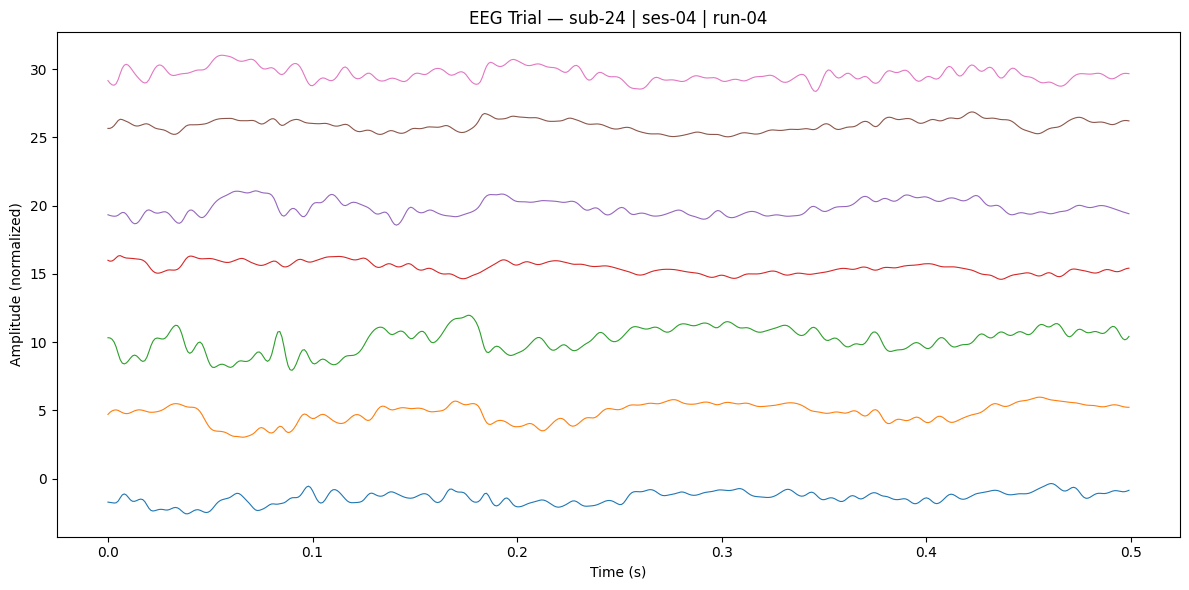

In [18]:
# %%
x_batch, y_batch = next(iter(loaders["train"]))

x_trial = x_batch[0]
meta = {k: v[0] for k, v in y_batch.items() if isinstance(v, list)}

print("Subject:", meta["subject"])
print("Session:", meta["session"])
print("Run:", meta["run"])
print("Category:", meta["category"])

plot_eeg_trial(x_trial, title=f"EEG Trial — {meta['subject']} | {meta['session']} | {meta['run']}")

# Base Line Model

## Setup

In [8]:
# %%
model = EEGNetBL(num_channels=122, num_classes=20).to(device)

print("Model loaded. Parameters:", sum(p.numel() for p in model.parameters()))

summary(
    model,
    input_size=(1, 122, 500),
    depth=4,
    col_names=["kernel_size", "output_size", "num_params"],
    verbose=1
)

Model loaded. Parameters: 63412
Layer (type:depth-idx)                   Kernel Shape              Output Shape              Param #
EEGNetBL                                 --                        [1, 20]                   --
├─Sequential: 1-1                        --                        [1, 8, 501]               --
│    └─Conv1d: 2-1                       [64]                      [1, 8, 501]               62,464
│    └─BatchNorm1d: 2-2                  --                        [1, 8, 501]               16
│    └─ELU: 2-3                          --                        [1, 8, 501]               --
├─Sequential: 1-2                        --                        [1, 16, 125]              --
│    └─Conv1d: 2-4                       [1]                       [1, 16, 501]              16
│    └─BatchNorm1d: 2-5                  --                        [1, 16, 501]              32
│    └─ELU: 2-6                          --                        [1, 16, 501]              --

Layer (type:depth-idx)                   Kernel Shape              Output Shape              Param #
EEGNetBL                                 --                        [1, 20]                   --
├─Sequential: 1-1                        --                        [1, 8, 501]               --
│    └─Conv1d: 2-1                       [64]                      [1, 8, 501]               62,464
│    └─BatchNorm1d: 2-2                  --                        [1, 8, 501]               16
│    └─ELU: 2-3                          --                        [1, 8, 501]               --
├─Sequential: 1-2                        --                        [1, 16, 125]              --
│    └─Conv1d: 2-4                       [1]                       [1, 16, 501]              16
│    └─BatchNorm1d: 2-5                  --                        [1, 16, 501]              32
│    └─ELU: 2-6                          --                        [1, 16, 501]              --
│    └─AvgPool1d: 2-7          

In [9]:
# %%
EPOCHS = config["num_epochs"]
LR = 3e-4

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

print("Training on:", device)

Training on: cuda


## Training

In [10]:
# %%
history = train_model(
    model=model,
    loaders=loaders,
    device=device,
    epochs=EPOCHS,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    checkpoint_dir=Path("checkpoints"),
    max_grad_norm=2.0
)

Epoch 1/100:   0%|                                                                                                                                                                                         | 0/122 [00:00<?, ?it/s]

Epoch 1/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:06<00:00, 20.03it/s]


Saved new best model at checkpoints/EEGNetBL_best_epoch01.pth (val acc=4.87%)
Epoch 01: Train loss=3.1043 | acc=5.28% | Val loss=3.0618 | acc=4.87%


Epoch 2/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.19it/s]


Saved new best model at checkpoints/EEGNetBL_best_epoch02.pth (val acc=5.29%)
Epoch 02: Train loss=3.0338 | acc=5.69% | Val loss=3.0297 | acc=5.29%


Epoch 3/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 30.06it/s]


Saved new best model at checkpoints/EEGNetBL_best_epoch03.pth (val acc=5.75%)
Epoch 03: Train loss=3.0111 | acc=5.85% | Val loss=3.0211 | acc=5.75%


Epoch 4/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.57it/s]


Saved new best model at checkpoints/EEGNetBL_best_epoch04.pth (val acc=5.90%)
Epoch 04: Train loss=3.0020 | acc=5.90% | Val loss=3.0243 | acc=5.90%


Epoch 5/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.93it/s]


Epoch 05: Train loss=2.9963 | acc=6.26% | Val loss=3.0151 | acc=5.62%


Epoch 6/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.59it/s]


Epoch 06: Train loss=2.9899 | acc=6.73% | Val loss=3.0111 | acc=5.79%


Epoch 7/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.97it/s]


Epoch 07: Train loss=2.9881 | acc=6.69% | Val loss=3.0160 | acc=5.69%


Epoch 8/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.41it/s]


Saved new best model at checkpoints/EEGNetBL_best_epoch08.pth (val acc=5.92%)
Epoch 08: Train loss=2.9849 | acc=6.96% | Val loss=3.0162 | acc=5.92%


Epoch 9/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.85it/s]


Epoch 09: Train loss=2.9818 | acc=7.18% | Val loss=3.0118 | acc=5.85%


Epoch 10/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.39it/s]


Epoch 10: Train loss=2.9808 | acc=7.26% | Val loss=3.0100 | acc=5.75%


Epoch 11/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 30.06it/s]


Saved new best model at checkpoints/EEGNetBL_best_epoch11.pth (val acc=6.37%)
Epoch 11: Train loss=2.9783 | acc=7.06% | Val loss=3.0163 | acc=6.37%


Epoch 12/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.83it/s]


Epoch 12: Train loss=2.9763 | acc=7.44% | Val loss=3.0098 | acc=5.87%


Epoch 13/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.83it/s]


Epoch 13: Train loss=2.9764 | acc=7.49% | Val loss=3.0111 | acc=5.98%


Epoch 14/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 30.18it/s]


Epoch 14: Train loss=2.9766 | acc=7.44% | Val loss=3.0136 | acc=6.04%


Epoch 15/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.93it/s]


Epoch 15: Train loss=2.9727 | acc=7.93% | Val loss=3.0173 | acc=6.04%


Epoch 16/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 30.22it/s]


Epoch 16: Train loss=2.9726 | acc=7.45% | Val loss=3.0161 | acc=5.67%


Epoch 17/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.83it/s]


Epoch 17: Train loss=2.9714 | acc=7.87% | Val loss=3.0165 | acc=5.63%


Epoch 18/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.98it/s]


Epoch 18: Train loss=2.9699 | acc=7.69% | Val loss=3.0178 | acc=6.06%


Epoch 19/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.78it/s]


Epoch 19: Train loss=2.9679 | acc=7.74% | Val loss=3.0155 | acc=6.15%


Epoch 20/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 30.18it/s]


Epoch 20: Train loss=2.9670 | acc=8.10% | Val loss=3.0217 | acc=5.65%


Epoch 21/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.26it/s]


Epoch 21: Train loss=2.9681 | acc=7.88% | Val loss=3.0142 | acc=6.06%


Epoch 22/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.88it/s]


Epoch 22: Train loss=2.9666 | acc=8.05% | Val loss=3.0169 | acc=5.94%


Epoch 23/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.84it/s]


Epoch 23: Train loss=2.9673 | acc=8.31% | Val loss=3.0175 | acc=5.73%


Epoch 24/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.62it/s]


Epoch 24: Train loss=2.9640 | acc=8.24% | Val loss=3.0217 | acc=5.56%


Epoch 25/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.99it/s]


Epoch 25: Train loss=2.9644 | acc=8.04% | Val loss=3.0168 | acc=5.88%


Epoch 26/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.75it/s]


Epoch 26: Train loss=2.9628 | acc=8.28% | Val loss=3.0223 | acc=5.88%


Epoch 27/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 30.28it/s]


Epoch 27: Train loss=2.9610 | acc=8.32% | Val loss=3.0212 | acc=5.40%


Epoch 28/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.55it/s]


Epoch 28: Train loss=2.9640 | acc=8.01% | Val loss=3.0184 | acc=6.25%


Epoch 29/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 30.03it/s]


Epoch 29: Train loss=2.9624 | acc=8.39% | Val loss=3.0213 | acc=5.85%


Epoch 30/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.65it/s]


Epoch 30: Train loss=2.9617 | acc=8.31% | Val loss=3.0215 | acc=5.94%


Epoch 31/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.96it/s]


Epoch 31: Train loss=2.9607 | acc=8.34% | Val loss=3.0193 | acc=6.19%


Epoch 32/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 30.13it/s]


Epoch 32: Train loss=2.9606 | acc=8.31% | Val loss=3.0210 | acc=6.27%


Epoch 33/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.56it/s]


Epoch 33: Train loss=2.9597 | acc=8.02% | Val loss=3.0214 | acc=6.12%


Epoch 34/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 30.02it/s]


Epoch 34: Train loss=2.9593 | acc=8.33% | Val loss=3.0248 | acc=6.04%


Epoch 35/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.63it/s]


Epoch 35: Train loss=2.9597 | acc=8.24% | Val loss=3.0244 | acc=5.67%


Epoch 36/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 30.27it/s]


Epoch 36: Train loss=2.9587 | acc=8.28% | Val loss=3.0241 | acc=5.83%


Epoch 37/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.71it/s]


Epoch 37: Train loss=2.9571 | acc=8.46% | Val loss=3.0222 | acc=6.21%


Epoch 38/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 30.02it/s]


Epoch 38: Train loss=2.9569 | acc=8.52% | Val loss=3.0244 | acc=5.79%


Epoch 39/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.55it/s]


Epoch 39: Train loss=2.9562 | acc=8.49% | Val loss=3.0260 | acc=5.73%


Epoch 40/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 30.24it/s]


Epoch 40: Train loss=2.9551 | acc=8.67% | Val loss=3.0265 | acc=6.17%


Epoch 41/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.91it/s]


Epoch 41: Train loss=2.9567 | acc=8.27% | Val loss=3.0240 | acc=5.90%


Epoch 42/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.72it/s]


Epoch 42: Train loss=2.9556 | acc=8.56% | Val loss=3.0263 | acc=6.02%


Epoch 43/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.92it/s]


Epoch 43: Train loss=2.9559 | acc=8.49% | Val loss=3.0255 | acc=5.96%


Epoch 44/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.75it/s]


Epoch 44: Train loss=2.9542 | acc=8.58% | Val loss=3.0275 | acc=5.96%


Epoch 45/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 30.05it/s]


Epoch 45: Train loss=2.9550 | acc=8.52% | Val loss=3.0258 | acc=6.04%


Epoch 46/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.54it/s]


Epoch 46: Train loss=2.9537 | acc=8.32% | Val loss=3.0288 | acc=5.63%


Epoch 47/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 30.08it/s]


Epoch 47: Train loss=2.9545 | acc=8.69% | Val loss=3.0299 | acc=6.10%


Epoch 48/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.45it/s]


Epoch 48: Train loss=2.9530 | acc=8.63% | Val loss=3.0289 | acc=5.69%


Epoch 49/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.61it/s]


Epoch 49: Train loss=2.9529 | acc=8.75% | Val loss=3.0263 | acc=5.73%


Epoch 50/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 30.16it/s]


Epoch 50: Train loss=2.9536 | acc=8.62% | Val loss=3.0273 | acc=5.83%


Epoch 51/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 30.23it/s]


Epoch 51: Train loss=2.9537 | acc=8.71% | Val loss=3.0273 | acc=5.77%


Epoch 52/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.83it/s]


Epoch 52: Train loss=2.9527 | acc=8.85% | Val loss=3.0285 | acc=5.48%


Epoch 53/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.90it/s]


Epoch 53: Train loss=2.9512 | acc=9.11% | Val loss=3.0293 | acc=5.81%


Epoch 54/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.85it/s]


Epoch 54: Train loss=2.9521 | acc=8.37% | Val loss=3.0295 | acc=5.77%


Epoch 55/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 30.13it/s]


Epoch 55: Train loss=2.9514 | acc=8.96% | Val loss=3.0311 | acc=5.96%


Epoch 56/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.86it/s]


Epoch 56: Train loss=2.9508 | acc=8.68% | Val loss=3.0295 | acc=5.87%


Epoch 57/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 30.47it/s]


Epoch 57: Train loss=2.9504 | acc=8.57% | Val loss=3.0282 | acc=5.85%


Epoch 58/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.26it/s]


Epoch 58: Train loss=2.9503 | acc=8.70% | Val loss=3.0316 | acc=5.58%


Epoch 59/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 30.22it/s]


Epoch 59: Train loss=2.9503 | acc=8.92% | Val loss=3.0295 | acc=5.60%


Epoch 60/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.90it/s]


Epoch 60: Train loss=2.9495 | acc=8.84% | Val loss=3.0303 | acc=5.71%


Epoch 61/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.45it/s]


Epoch 61: Train loss=2.9493 | acc=8.74% | Val loss=3.0298 | acc=5.73%


Epoch 62/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.93it/s]


Epoch 62: Train loss=2.9493 | acc=8.97% | Val loss=3.0308 | acc=5.77%


Epoch 63/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.87it/s]


Epoch 63: Train loss=2.9499 | acc=9.09% | Val loss=3.0287 | acc=5.88%


Epoch 64/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.88it/s]


Epoch 64: Train loss=2.9486 | acc=8.96% | Val loss=3.0302 | acc=5.90%


Epoch 65/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.77it/s]


Epoch 65: Train loss=2.9464 | acc=9.01% | Val loss=3.0303 | acc=5.65%


Epoch 66/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 30.31it/s]


Epoch 66: Train loss=2.9480 | acc=8.98% | Val loss=3.0309 | acc=5.90%


Epoch 67/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.70it/s]


Epoch 67: Train loss=2.9491 | acc=8.87% | Val loss=3.0324 | acc=5.85%


Epoch 68/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 30.19it/s]


Epoch 68: Train loss=2.9466 | acc=9.04% | Val loss=3.0299 | acc=5.77%


Epoch 69/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.40it/s]


Epoch 69: Train loss=2.9484 | acc=8.94% | Val loss=3.0327 | acc=5.79%


Epoch 70/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.90it/s]


Epoch 70: Train loss=2.9458 | acc=8.94% | Val loss=3.0322 | acc=5.67%


Epoch 71/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 30.06it/s]


Epoch 71: Train loss=2.9465 | acc=8.99% | Val loss=3.0332 | acc=5.33%


Epoch 72/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.80it/s]


Epoch 72: Train loss=2.9465 | acc=8.93% | Val loss=3.0328 | acc=5.71%


Epoch 73/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 30.10it/s]


Epoch 73: Train loss=2.9473 | acc=9.13% | Val loss=3.0341 | acc=5.65%


Epoch 74/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.48it/s]


Epoch 74: Train loss=2.9456 | acc=8.94% | Val loss=3.0335 | acc=5.88%


Epoch 75/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.97it/s]


Epoch 75: Train loss=2.9461 | acc=9.10% | Val loss=3.0325 | acc=5.69%


Epoch 76/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.46it/s]


Epoch 76: Train loss=2.9465 | acc=8.96% | Val loss=3.0332 | acc=5.71%


Epoch 77/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 30.05it/s]


Epoch 77: Train loss=2.9449 | acc=9.20% | Val loss=3.0343 | acc=5.73%


Epoch 78/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.59it/s]


Epoch 78: Train loss=2.9455 | acc=9.17% | Val loss=3.0339 | acc=5.71%


Epoch 79/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.78it/s]


Epoch 79: Train loss=2.9442 | acc=9.42% | Val loss=3.0338 | acc=5.71%


Epoch 80/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 30.27it/s]


Epoch 80: Train loss=2.9438 | acc=9.31% | Val loss=3.0338 | acc=5.50%


Epoch 81/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.53it/s]


Epoch 81: Train loss=2.9444 | acc=9.24% | Val loss=3.0345 | acc=5.52%


Epoch 82/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.90it/s]


Epoch 82: Train loss=2.9451 | acc=8.87% | Val loss=3.0337 | acc=5.63%


Epoch 83/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.65it/s]


Epoch 83: Train loss=2.9446 | acc=9.02% | Val loss=3.0341 | acc=5.38%


Epoch 84/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 30.22it/s]


Epoch 84: Train loss=2.9439 | acc=9.15% | Val loss=3.0336 | acc=5.63%


Epoch 85/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.65it/s]


Epoch 85: Train loss=2.9444 | acc=9.29% | Val loss=3.0343 | acc=5.56%


Epoch 86/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.98it/s]


Epoch 86: Train loss=2.9437 | acc=9.24% | Val loss=3.0350 | acc=5.75%


Epoch 87/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.65it/s]


Epoch 87: Train loss=2.9447 | acc=9.30% | Val loss=3.0344 | acc=5.73%


Epoch 88/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.86it/s]


Epoch 88: Train loss=2.9442 | acc=9.19% | Val loss=3.0348 | acc=5.71%


Epoch 89/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 30.07it/s]


Epoch 89: Train loss=2.9432 | acc=8.89% | Val loss=3.0345 | acc=5.81%


Epoch 90/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.49it/s]


Epoch 90: Train loss=2.9448 | acc=9.28% | Val loss=3.0352 | acc=5.75%


Epoch 91/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.90it/s]


Epoch 91: Train loss=2.9444 | acc=9.24% | Val loss=3.0337 | acc=5.67%


Epoch 92/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.75it/s]


Epoch 92: Train loss=2.9430 | acc=9.33% | Val loss=3.0347 | acc=5.71%


Epoch 93/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.73it/s]


Epoch 93: Train loss=2.9439 | acc=9.31% | Val loss=3.0350 | acc=5.62%


Epoch 94/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.36it/s]


Epoch 94: Train loss=2.9445 | acc=8.99% | Val loss=3.0347 | acc=5.63%


Epoch 95/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.14it/s]


Epoch 95: Train loss=2.9424 | acc=9.28% | Val loss=3.0348 | acc=5.65%


Epoch 96/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.98it/s]


Epoch 96: Train loss=2.9424 | acc=8.93% | Val loss=3.0344 | acc=5.65%


Epoch 97/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 30.00it/s]


Epoch 97: Train loss=2.9441 | acc=9.14% | Val loss=3.0350 | acc=5.69%


Epoch 98/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.49it/s]


Epoch 98: Train loss=2.9423 | acc=9.42% | Val loss=3.0342 | acc=5.63%


Epoch 99/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 30.25it/s]


Epoch 99: Train loss=2.9422 | acc=9.29% | Val loss=3.0342 | acc=5.73%


Epoch 100/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.73it/s]


Epoch 100: Train loss=2.9444 | acc=9.26% | Val loss=3.0351 | acc=5.73%
\Training complete. Best epoch 11 with val acc=6.37%


## Evaluation

In [11]:
# Load best model
model.load_state_dict(history["best_state_dict"])
print(f"Loaded best model from epoch {history['best_epoch']} "
      f"with val acc={history['best_val_acc']*100:.2f}%.")

Loaded best model from epoch 11 with val acc=6.37%.


In [12]:
# %%
model.eval()
correct = total = 0

with torch.no_grad():
    for xb, meta in loaders["test"]:
        preds = model(xb.to(device)).argmax(dim=1)
        y = meta["class_id"].to(device)
        correct += (preds == y).sum().item()
        total += len(y)

print(f"Test accuracy: {100 * correct/total:.2f}%")

Test accuracy: 6.04%


In [13]:
# %%
all_preds, all_labels = collect_predictions(model, loaders["test"], device)
print("Collected predictions:", len(all_preds))

Collected predictions: 5200



 Running full evaluation on test set...



Collected 5200 predictions.

 Generating confusion matrix...


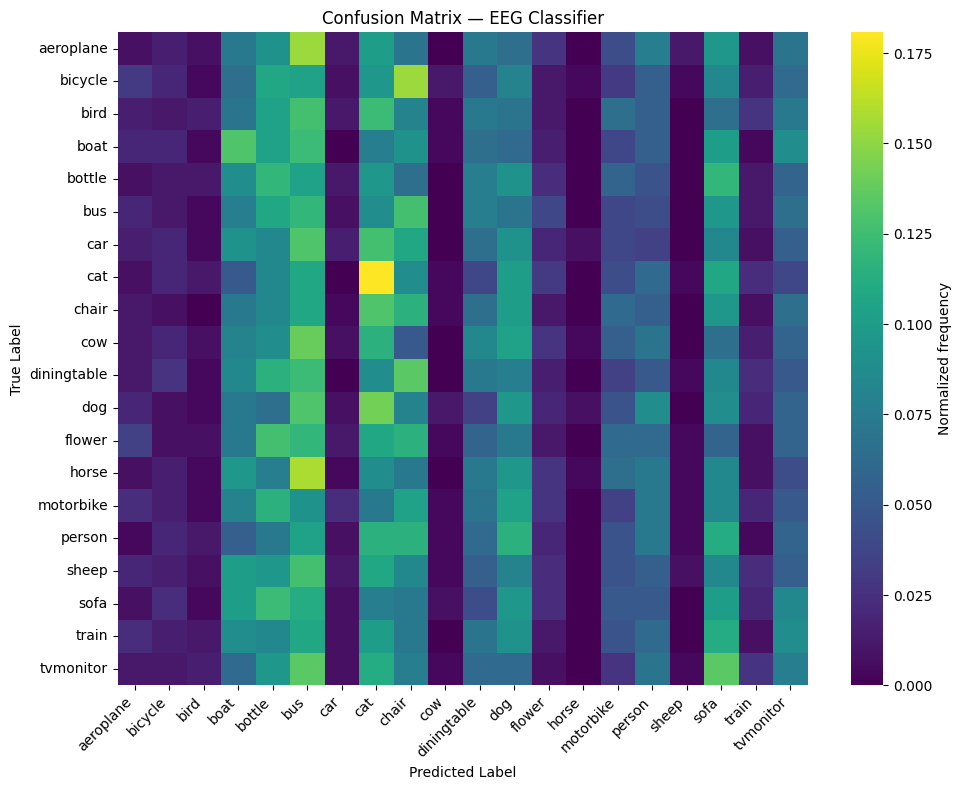


 Computing per-class accuracy...
       Category  Accuracy (%)
7           cat         18.08
3          boat         13.08
4        bottle         11.92
5           bus         11.92
8         chair         11.54
17         sofa         10.00
11          dog          9.62
19    tvmonitor          7.69
15       person          7.31
10  diningtable          7.31
14    motorbike          3.46
1       bicycle          1.92
6           car          1.54
2          bird          1.54
12       flower          1.15
0     aeroplane          0.77
18        train          0.77
16        sheep          0.77
13        horse          0.38
9           cow          0.00

 Computing global metrics...
          Metric  Value (%)
0   Accuracy (%)   6.038462
1  Precision (%)   6.520082
2     Recall (%)   6.038462
3   F1-score (%)   4.831571

 Identifying most common confusion pairs...
          True Predicted  Count
0        horse       bus     41
1    aeroplane       bus     40
2      bicycle     chair 

In [14]:
print("\n Running full evaluation on test set...")
cm, per_class_df, summary_df, confusion_pairs_df = evaluate_model(
    model,
    loaders["test"],
    device=device,
    save_dir="results/"     # saves LaTeX + CSV tables
)

In [15]:
# ===== New Cell: Export evaluation results =====

per_class_df.to_csv("results/per_class_accuracy.csv", index=False)
summary_df.to_csv("results/global_metrics.csv", index=False)
confusion_pairs_df.to_csv("results/top_confusions.csv", index=False)

print("Results exported to results/ folder.")

Results exported to results/ folder.


# Improved Model

## Setup

In [19]:
subjects = sorted(index_df["subject"].unique())
subj2idx = {s: i for i, s in enumerate(subjects)}
print("Subjects + indices:", subj2idx)

Subjects + indices: {'sub-02': 0, 'sub-03': 1, 'sub-05': 2, 'sub-09': 3, 'sub-14': 4, 'sub-15': 5, 'sub-17': 6, 'sub-19': 7, 'sub-20': 8, 'sub-23': 9, 'sub-24': 10, 'sub-28': 11, 'sub-29': 12}


In [20]:
if config['model_to_use'] == "Multihead":
    model_mh = MultiHeadEEGClassifier(
        num_channels=122,
        num_classes=20,
        n_subjects=len(subj2idx),
        hidden_dim=256,
        n_layers=6,
        n_heads=8,
        ff_mult=4,
        dropout=0.3,
    )
elif config['model_to_use'] == "Multiscale":
    model_mh = MultiScaleEEGTransformerMH(
        num_channels=122,
        num_classes=20,
        n_subjects=len(subj2idx),
        hidden_dim=128,           # per branch
        transformer_dim=256,      # final embedding size
        n_layers=4,
        n_heads=4,
        ff_mult=4,
        dropout=0.1,
    )
model_mh = model_mh.to(device)

In [21]:
print(f"{config['model_to_use']} model parameters:",
      sum(p.numel() for p in model_mh.parameters() if p.requires_grad))

# Torchinfo summary – we must pass BOTH x and subj_idx as input_data
dummy_x = torch.randn(1, 122, 500).to(device)   # [B, C, T]
dummy_subj = torch.tensor([0], dtype=torch.long).to(device)

summary(
    model_mh,
    input_data=(dummy_x, dummy_subj),
    depth=4,
    col_names=["kernel_size", "output_size", "num_params"],
    verbose=0
)

Multiscale model parameters: 4304132


Layer (type:depth-idx)                             Kernel Shape              Output Shape              Param #
MultiScaleEEGTransformerMH                         --                        [1, 20]                   --
├─MultiScaleConvBlock: 1-1                         --                        [1, 384, 500]             --
│    └─Conv1d: 2-1                                 [7]                       [1, 128, 500]             109,440
│    └─Conv1d: 2-2                                 [15]                      [1, 128, 500]             234,368
│    └─Conv1d: 2-3                                 [31]                      [1, 128, 500]             484,224
│    └─BatchNorm1d: 2-4                            --                        [1, 384, 500]             768
│    └─GELU: 2-5                                   --                        [1, 384, 500]             --
├─DepthwiseSeparableConv: 1-2                      --                        [1, 384, 500]             --
│    └─Conv1d: 2-6       

In [22]:
optimizer = optim.AdamW(
    model_mh.parameters(),
    lr=config['lr'],
    weight_decay=config['weight_decay'],
    betas=(0.9, 0.98),
)

scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=config["num_epochs"],
    eta_min=1e-5
)


criterion = nn.CrossEntropyLoss(label_smoothing=config['label_smoothing'])

## Training

In [23]:
history_mh = train_multihead_model(
    model=model_mh,
    loaders=loaders,
    device=device,
    epochs=config["num_epochs"],
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    checkpoint_dir="checkpoints_multihead",
    max_grad_norm=config['max_grad_norm'],
    subj2idx=subj2idx,
)

[Train] Epoch 1/2:   0%|                                                                                                                                                                   | 0/122 [00:00<?, ?it/s]

[Train] Epoch 1/2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:33<00:00,  3.60it/s]


Epoch 01 | Train loss=3.0726 acc=4.74% | Val loss=3.0456 acc=5.25%
New best model at epoch 1 (val acc=5.25%)


[Train] Epoch 2/2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:33<00:00,  3.69it/s]


Epoch 02 | Train loss=2.9599 acc=8.53% | Val loss=3.0372 acc=5.31%
New best model at epoch 2 (val acc=5.31%)

Training complete. Best epoch=2 val acc=5.31%


## Evaluation

In [24]:
model_mh.load_state_dict(history_mh["best_state_dict"])
print(f"Loaded best multi-head model from epoch {history_mh['best_epoch']} "
      f"(val acc={history_mh['best_val_acc']*100:.2f}%).")

Loaded best multi-head model from epoch 2 (val acc=5.31%).


In [25]:
# %%
def collect_predictions_multihead(model, loader, device, subj2idx):
    """
    Run model over a loader and collect predictions + labels for multi-head model.
    model(x, subj_idx) -> logits
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for xb, meta in tqdm(loader, desc="Evaluating (multi-head)"):
            x = xb.to(device)
            y = meta["class_id"].to(device)

            subj_idx = torch.tensor(
                [subj2idx[s] for s in meta["subject"]],
                dtype=torch.long,
                device=device,
            )

            logits = model(x, subj_idx)
            preds = logits.argmax(dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    return all_preds, all_labels

# Collect predictions on test set
mh_preds, mh_labels = collect_predictions_multihead(
    model_mh, loaders["test"], device, subj2idx
)
print("Collected multi-head predictions:", len(mh_preds))

Evaluating (multi-head): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:03<00:00, 11.28it/s]


Collected multi-head predictions: 5200


In [26]:
# %%
test_acc_mh = accuracy_score(mh_labels, mh_preds)
print(f"Multi-head Test Accuracy: {test_acc_mh*100:.2f}%")

Multi-head Test Accuracy: 5.31%


Confusion matrix saved at results/Finetune_Multihead/confusion_matrix.png


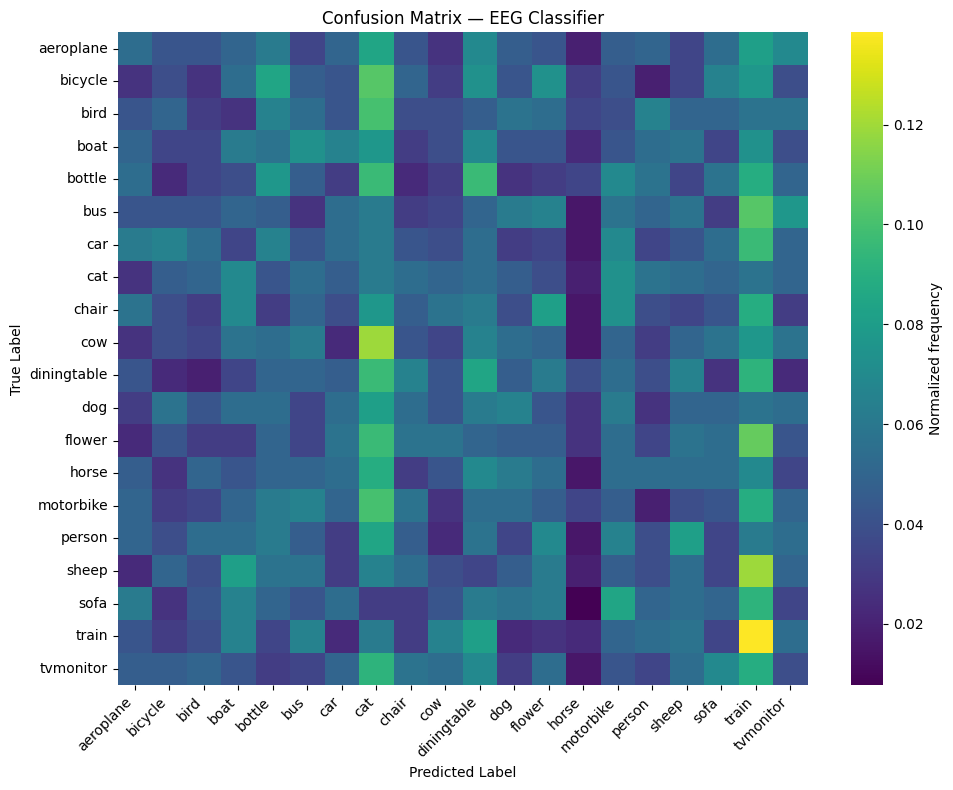

       Category  Accuracy (%)
18        train         13.85
10  diningtable          8.46
4        bottle          7.69
11          dog          6.54
7           cat          6.15
          Metric  Value (%)
0   Accuracy (%)   5.307692
1  Precision (%)   5.164542
2     Recall (%)   5.307692
3   F1-score (%)   5.145179
[('cow', 'cat', np.int64(31)), ('sheep', 'train', np.int64(31)), ('flower', 'train', np.int64(28)), ('bicycle', 'cat', np.int64(27)), ('bus', 'train', np.int64(27)), ('bird', 'cat', np.int64(26)), ('motorbike', 'cat', np.int64(26)), ('bottle', 'cat', np.int64(25)), ('bottle', 'diningtable', np.int64(25)), ('car', 'train', np.int64(25))]


In [27]:
# Confusion matrix
cm_mh = plot_confusion_matrix(
    mh_labels,
    mh_preds,
    normalize=True,
    save_path=f"{config['results_path']}/confusion_matrix.png"
)

# Per-class accuracy
per_class_df_mh = compute_per_class_accuracy(mh_labels, mh_preds)
print(per_class_df_mh.head())

# Global metrics
metrics_dict_mh = compute_global_metrics(mh_labels, mh_preds)
summary_df_mh = metrics_to_dataframe(metrics_dict_mh)
print(summary_df_mh)

# Top confusing pairs
confusion_pairs_df_mh = top_confusion_pairs(mh_labels, mh_preds, top_k=10)
print(confusion_pairs_df_mh)

In [28]:
per_class_df_mh.to_csv(save_dir / "per_class_accuracy.csv", index=False)
summary_df_mh.to_csv(save_dir / "global_metrics.csv", index=False)
# Top confusion pairs (list of tuples)
confusion_pairs_mh = top_confusion_pairs(mh_labels, mh_preds, top_k=10)

# Convert to DataFrame
confusion_pairs_df_mh = pd.DataFrame(
    confusion_pairs_mh,
    columns=["True Label", "Predicted Label", "Count"]
)

print(confusion_pairs_df_mh)

# Save
confusion_pairs_df_mh.to_csv(save_dir / "top_confusions.csv", index=False)

with open(save_dir / "per_class_accuracy.tex", "w") as f:
    f.write(per_class_df_mh.to_latex(index=False, float_format="%.2f"))

with open(save_dir / "global_metrics.tex", "w") as f:
    f.write(summary_df_mh.to_latex(index=False, float_format="%.2f"))

print("Multi-head evaluation tables saved in results_multihead/")

  True Label Predicted Label  Count
0        cow             cat     31
1      sheep           train     31
2     flower           train     28
3    bicycle             cat     27
4        bus           train     27
5       bird             cat     26
6  motorbike             cat     26
7     bottle             cat     25
8     bottle     diningtable     25
9        car           train     25


Multi-head evaluation tables saved in results_multihead/


# Implement best model for CLIP layer

In [29]:
# Make sure best weights from training are loaded
model_mh.load_state_dict(history_mh["best_state_dict"])
model_mh.eval()
model_mh.to(device)

export_all_splits_multihead(
    model_mh, loaders, device, subj2idx,
    save_dir=config['results_path']
)

print("\nEEG embeddings saved in:", config['results_path'])


=== Exporting split: train ===
Collected 15600 embeddings, dim=256
Saved embeddings to: results/Finetune_Multihead/multihead_train_embeddings.npy
Saved metadata  to: results/Finetune_Multihead/multihead_train_meta.csv
Shape: embeddings=(15600, 256), rows=15600

=== Exporting split: val ===
Collected 5200 embeddings, dim=256
Saved embeddings to: results/Finetune_Multihead/multihead_val_embeddings.npy
Saved metadata  to: results/Finetune_Multihead/multihead_val_meta.csv
Shape: embeddings=(5200, 256), rows=5200

=== Exporting split: test ===
Collected 5200 embeddings, dim=256
Saved embeddings to: results/Finetune_Multihead/multihead_test_embeddings.npy
Saved metadata  to: results/Finetune_Multihead/multihead_test_meta.csv
Shape: embeddings=(5200, 256), rows=5200

EEG embeddings saved in: results/Finetune_Multihead
